<a href="https://colab.research.google.com/github/juno2856/deeplearning/blob/master/NLP/%EC%9E%90%EC%97%B0%EC%96%B4%EC%B2%98%EB%A6%AC_20220518.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 네이버 영화 리뷰 감성 분석

## 1. 데이터 준비와 확인
https://wikidocs.net/44249

In [ ]:
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
import re
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt") # train
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt") # test
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt") # train + test

('ratings.txt', <http.client.HTTPMessage at 0x7f7bc425a150>)

In [ ]:
train_data =pd.read_table('ratings_train.txt')
test_data =pd.read_table('ratings_test.txt')

In [ ]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [ ]:
!pip install konlpy
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git 
%cd Mecab-ko-for-Google-Colab/
!bash install_mecab-ko_on_colab190912.sh
%cd ../

# **2. 데이터로더 구성**

In [ ]:
from konlpy.tag import Mecab
tokenizer = Mecab()

In [ ]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [ ]:
def tokenize_and_remove_stopwords(data, stopwords, tokenizer):
    result = []

    for sentence in data:
      curr_data = []
      curr_data = tokenizer.morphs(sentence) # mecab 형태소 분석 tokenizer
      curr_data = [word for word in curr_data if not word in stopwords] # 불용어 제거
      result.append(curr_data)
    return result

In [ ]:
def load_data(train_data, test_data, num_words =10000):
  
  # 중복 제거
  train_data.drop_duplicates(subset=['document'], inplace = True)
  test_data.drop_duplicates(subset = ['document'], inplace = True)

  # Nan 결축지 제거
  train_data = train_data.dropna(how = 'any')
  test_data = test_data.dropna(how = 'any')

  # 토큰화 및 불용어 제거
  x_train = tokenize_and_remove_stopwords(train_data['document'], stopwords, tokenizer)
  x_test = tokenize_and_remove_stopwords(test_data['document'], stopwords, tokenizer)


  # 단어장 만드는 중..
  words = np.concatenate(x_train).tolist()
  counter = Counter(words)
  counter = counter.most_common(10000-4)    #빈도수
  # print(counter)
  vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
  # print(vocab)
  word_to_index = {word:index for index, word in enumerate(vocab)}

  def wordlist_to_indexlist(wordlist):
      return [word_to_index[word] if word in word_to_index else word_to_index ['<UNK>'] for word in wordlist]

  x_train = list(map(wordlist_to_indexlist, x_train))
  x_test = list(map(wordlist_to_indexlist, x_test))

  return x_train, np.array(list(train_data['label'])), x_test, np.array(list(test_data['label'])), word_to_index


In [ ]:
x_train, y_train, x_test, y_test, word_to_index = load_data(train_data, test_data)

In [ ]:
print(x_train[10])

[2, 4, 39, 229, 6, 535]


In [ ]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [ ]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수
# 단, 모든 문장은 <BOS>로 시작하는 것을 말합니다.

def get_encoded_sentence(sentence, word_to_index): #text -> 숫자
  return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>']  for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode 해주는 함수입니다.
def get_encoded_sentences(sentences, word_to_index):
  return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode 하는 함수 입니다.
def get_decoded_sentence(encoded_sentence, index_to_word):
  return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수 입니다.
def get_decoded_sentences(encoded_sentences, index_to_word):
  return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [ ]:
get_decoded_sentence(x_train[10], index_to_word)

'. 진짜 짱 다 ♥'

In [ ]:
get_encoded_sentence('. 진짜 짱 다 ♥', word_to_index)

[1, 4, 39, 229, 6, 535]

# **3. 모델 구성을 위한 데이터 분석 및 가공**

In [ ]:
#데이터 셋 내 문장 길이 분포
total_data_text = list(x_train) + list(x_test)

# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장 길이의 평균값, 최댓값, 표준편차를 계산
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를 들면 최대길이를 (평균 +2*표준편차)로 한다면,
max_tokens = np.mean(num_tokens) +2*np.std(num_tokens)

maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함된다.'.format(np.sum(num_tokens < max_tokens)/len(num_tokens)))

문장길이 평균 :  15.96938143432699
문장길이 최대 :  116
문장길이 표준편차 :  12.843571939469296
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함된다.


In [ ]:
# 패딩 추가
x_train = pad_sequences(x_train, value = word_to_index['<PAD>'], padding = 'pre', maxlen = maxlen)
x_test = pad_sequences(x_test, value = word_to_index['<PAD>'], padding = 'pre', maxlen = maxlen)

In [ ]:
print(x_train.shape)
print(x_test.shape)

(146182, 41)
(49157, 41)


# 4. 모델 구성 및 vaildation 구성

In [ ]:
vocab_size = 10000
word_vector_dim = 200 # 2의 배수로 지정


model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(8, activation = 'relu'))
model.add(keras.layers.Dense(1, activation = 'sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 200)         2000000   
                                                                 
 lstm (LSTM)                 (None, 8)                 6688      
                                                                 
 dense (Dense)               (None, 8)                 72        
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2,006,769
Trainable params: 2,006,769
Non-trainable params: 0
_________________________________________________________________


# **모델 훈련**


In [ ]:
x_val = x_train[:50000]
y_val = y_train[:50000]

partial_x_train = x_train[50000:]
partial_y_train = y_train[50000:]

In [ ]:
model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])
epochs = 100

In [ ]:
history = model.fit(partial_x_train, partial_y_train, epochs = epochs, 
                    batch_size = 512, validation_data = (x_val, y_val), verbose = 1)

In [ ]:
results = model.evaluate(x_test, y_test, verbose = 2)

1537/1537 - 5s - loss: 1.7564 - accuracy: 0.8142 - 5s/epoch - 4ms/step


In [ ]:
print(results)

[1.7563680410385132, 0.8141668438911438]


# 6. loss, accuracy 그래프 시각화

In [ ]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [ ]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

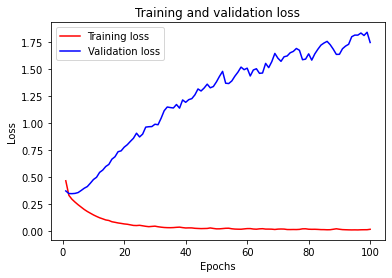

In [ ]:
epochs = range(1, len(acc)+1)

plt.plot(epochs, loss, 'r-', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

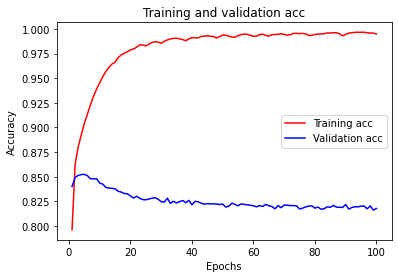

In [ ]:
plt.plot(epochs, acc, 'r-', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Proj: 네이버 영화 리뷰 감성 분류에 SentencePiece적용하기

*   네이버 영화리뷰 감정 분석 코퍼스에 SentencePiece를 적용시킨 모델 학습하기
*   학습된 모델로 sp_tokenize() 메소드 구현하기
*   구현된 토크나이저를 적용하여 네이버 영화리뷰 감정 분석 모델을 재학습하기
*   KoNLPy 형태소 분석기를 사용한 모델과 성능 비교하기
*   (보너스) SentencePiece 모델의 model_type, vocab_size 등을 변경해 가면서 성능 개선 여부 확인하기






